In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 14.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 2.7 MB/s eta 0:00:00


In [ ]:
import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gymnasium as gym

In [ ]:
def select_elites(states_batch, actions_batch,
                  returns_batch, percentile=50):
    """
    Выбирает состояния и действия с заданным перцентилем (rewards >= percentile)
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of session returns, returns_batch[session_i]

    :returns: elite_states, elite_actions - одномерные
    списки состояния и действия, выбранных сессий
    """
    # нужно найти порог вознаграждения по процентилю
    # reward_threshold =
    """<codehere>"""
    return_threshold = np.percentile(returns_batch, percentile)
    """</codehere>"""


    # в соответствии с найденным порогом - заполнить списки
    # elite_states и elite_actions, нужными состояниями и действиями
    elite_states = []
    elite_actions = []
    """<codehere>"""
    for index, session_return in enumerate(returns_batch):
        if session_return >= return_threshold:
            elite_states += states_batch[index]
            elite_actions += actions_batch[index]
    """</codehere>"""

    return elite_states, elite_actions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from IPython.display import clear_output

def show_progress(returns_batch, log, percentile, return_range=[-990, +10]):
    """
    Удобная функция, для визуализации результатов.
    """

    mean_return = np.mean(returns_batch)
    threshold = np.percentile(returns_batch, percentile)
    log.append([mean_return, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean returns')
    plt.plot(list(zip(*log))[1], label='Return thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(returns_batch, range=return_range)
    plt.vlines([np.percentile(returns_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean return = %.3f, threshold=%.3f" % (mean_return, threshold))
    plt.show()

## Deep CEM. Закапываемся глубже.

В данной части мы рассмотрим применение CEM вместе с нейронной сетью.
Будем обучать многослойную нейронную сеть для решения простой задачи с непрерывным пространством действий.

<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2020/RL/figures/digging.svg">

Будем тестировать нашего нового агента на известной задаче перевернутого маятника, с непрерывным пространством состояний.
https://gym.openai.com/envs/CartPole-v0/

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

print(f"состояний: {state_dim} действий: {n_actions}")

состояний: 4 действий: 2


### Стратегия с нейронной сетью

Попробуем заменить метод обновления вероятностей на нейронную сеть.
Будем пользоваться упрощенной реализацией нейронной сети из пакета Scikit-learn.
Нам потребуется:
* agent.partial_fit(states, actions) - делает один проход обучения по данным. Максимизирует вероятность :actions: из :states:
* agent.predict_proba(states) - предсказыает вероятность каждого из действий, в виде матрицы размера [len(states), n_actions]

In [ ]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# инициализируем агента под заданное пространство состояний и действий
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [ ]:
def generate_session(env, agent, t_max=1000):

    states,actions = [],[]
    session_return = 0

    s, info = env.reset()

    for t in range(t_max):
        # предсказываем вероятности действий по сети и
        # выбираем одно действие
        # probs =
        # a =
        ####### Здесь ваш код ########
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        ##############################

        new_s, r, terminated, truncated, info = env.step(a)

        states.append(s)
        actions.append(a)
        session_return += r

        s = new_s
        if terminated:
            break
    return states, actions, session_return

In [ ]:
dummy_states, dummy_actions, dummy_return = generate_session(env, agent, t_max=5)
print("состояния:", np.stack(dummy_states))
print("действия:", dummy_actions)
print("отдача:", dummy_return)

состояния: [[ 0.02728548  0.01774823 -0.04855999  0.02871338]
 [ 0.02764045 -0.17664492 -0.04798572  0.30568835]
 [ 0.02410755  0.01912683 -0.04187195 -0.00173363]
 [ 0.02449008  0.21482348 -0.04190663 -0.3073281 ]
 [ 0.02878655  0.02032295 -0.04805319 -0.02815038]]
действия: [0, 1, 1, 0, 1]
отдача: 5.0


mean return = 203.890, threshold=194.000


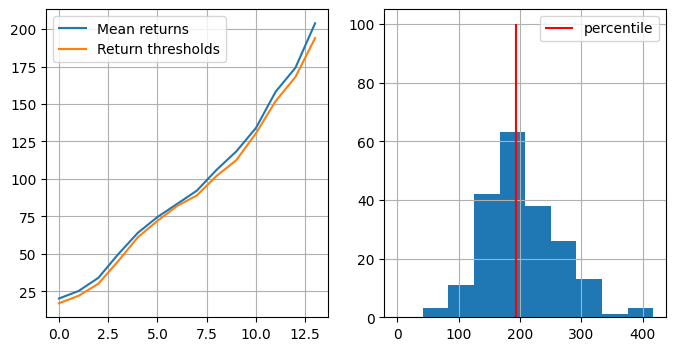

Принято!


In [ ]:
n_sessions = 200
percentile = 50
log = []

for i in range(100):
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, returns_batch = map(list, zip(*sessions))
    elite_states, elite_actions = select_elites(
        states_batch, actions_batch, returns_batch, percentile
    )

    # учим стратегию предсказывать в состояниях X=elite_states,
    # действия y=elite_actions
    """<codehere>"""
    agent.fit(elite_states, elite_actions)
    """</codehere>"""

    show_progress(returns_batch, log, percentile, return_range=[0, np.max(returns_batch)])

    if np.mean(returns_batch) > 190:
        print("Принято!")
        break


In [ ]:
env.close()

In [ ]:
from gymnasium.wrappers.record_video import RecordVideo

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, "./video")

generate_session(env, agent)

env.close()
show_video()

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
